In [166]:
!pip install tensorflow-datasets

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


# Generator 구성하기
---

## 데이터 준비하기

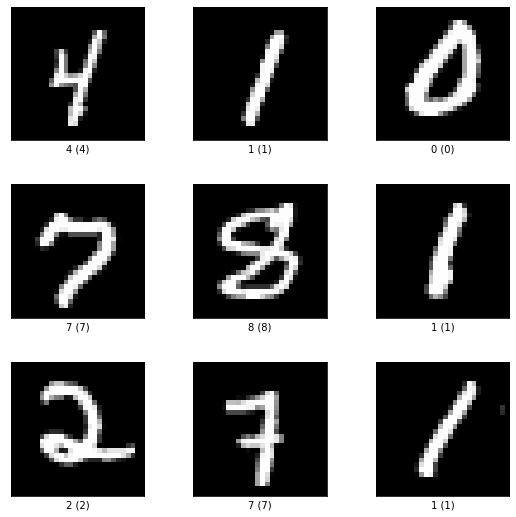

In [167]:
import tensorflow_datasets as tfds

mnist, info = tfds.load(
    "mnist", split="train", with_info=True
)

fig = tfds.show_examples(mnist, info)

In [168]:
import tensorflow as tf

BATCH_SIZE = 128

def gan_preprocessing(data):
    image = data["image"]
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    return image

def cgan_preprocessing(data):
    image = data["image"]
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    
    label = tf.one_hot(data["label"], 10)
    return image, label

gan_datasets = mnist.map(gan_preprocessing).shuffle(1000).batch(BATCH_SIZE)
cgan_datasets = mnist.map(cgan_preprocessing).shuffle(100).batch(BATCH_SIZE)
print("✅")

✅


In [169]:
import matplotlib.pyplot as plt

for i,j in cgan_datasets : break

# 이미지 i와 라벨 j가 일치하는지 확인해 봅니다.     
print("Label :", j[0])
print("Image Min/Max :", i.numpy().min(), i.numpy().max())
plt.imshow(i.numpy()[0,...,0], plt.cm.gray)

Label : tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0. 0.], shape=(10,), dtype=float32)
Image Min/Max : -1.0 1.0


## GAN Generator 구성하기



In [170]:
from tensorflow.keras import layers, Input, Model

class GeneratorGAN(Model):
    def __init__(self):
        super(GeneratorGAN, self).__init__()

        self.dense_1 = layers.Dense(128, activation='relu')
        self.dense_2 = layers.Dense(256, activation='relu')
        self.dense_3 = layers.Dense(512, activation='relu')
        self.dense_4 = layers.Dense(28*28*1, activation='tanh')

        self.reshape = layers.Reshape((28, 28, 1))

    def call(self, noise):
        out = self.dense_1(noise)
        out = self.dense_2(out)
        out = self.dense_3(out)
        out = self.dense_4(out)
        return self.reshape(out)

print("✅")

✅


## GAN Generator 구성하기

In [171]:
from tensorflow.keras import layers, Input, Model

class GeneratorGAN(Model):
    def __init__(self):
        super(GeneratorGAN, self).__init__()

        self.dense_1 = layers.Dense(128, activation='relu')
        self.dense_2 = layers.Dense(256, activation='relu')
        self.dense_3 = layers.Dense(512, activation='relu')
        self.dense_4 = layers.Dense(28*28*1, activation='tanh')

        self.reshape = layers.Reshape((28, 28, 1))

    def call(self, noise):
        out = self.dense_1(noise)
        out = self.dense_2(out)
        out = self.dense_3(out)
        out = self.dense_4(out)
        return self.reshape(out)

print("✅")

✅


## cGAN Generator 구성하기

In [172]:
class GeneratorCGAN(Model):
    def __init__(self):
        super(GeneratorCGAN, self).__init__()
        
        self.dense_z = layers.Dense(256, activation='relu')
        self.dense_y = layers.Dense(256, activation='relu')
        self.combined_dense = layers.Dense(512, activation='relu')
        self.final_dense = layers.Dense(28 * 28 * 1, activation='tanh')
        self.reshape = layers.Reshape((28, 28, 1))

    def call(self, noise, label):
        noise = self.dense_z(noise)
        label = self.dense_y(label)
        out = self.combined_dense(tf.concat([noise, label], axis=-1))
        out = self.final_dense(out)
        return self.reshape(out)
    
print("✅")

✅


# Discriminator 구성하기
---

## GAN Discriminator 구성하기

In [173]:
class DiscriminatorGAN(Model):
    def __init__(self):
        super(DiscriminatorGAN, self).__init__()
        self.flatten = layers.Flatten()
        
        self.blocks = []
        for f in [512, 256, 128, 1]:
            self.blocks.append(
                layers.Dense(f, activation=None if f==1 else "relu")
            )
        
    def call(self, x):
        x = self.flatten(x)
        for block in self.blocks:
            x = block(x)
        return x
    
print("✅")

✅


## cGAN Discriminator 구성하기

In [174]:
class Maxout(layers.Layer):
    def __init__(self, units, pieces):
        super(Maxout, self).__init__()
        self.dense = layers.Dense(units*pieces, activation="relu")
        self.dropout = layers.Dropout(.5)    
        self.reshape = layers.Reshape((-1, pieces, units))
    
    def call(self, x):
        x = self.dense(x)
        x = self.dropout(x)
        x = self.reshape(x)
        return tf.math.reduce_max(x, axis=1)

print("✅")

✅


In [175]:
class DiscriminatorCGAN(Model):
    def __init__(self):
        super(DiscriminatorCGAN, self).__init__()
        self.flatten = layers.Flatten()
        
        self.image_block = Maxout(240, 5)
        self.label_block = Maxout(50, 5)
        self.combine_block = Maxout(240, 4)
        
        self.dense = layers.Dense(1, activation=None)
    
    def call(self, image, label):
        image = self.flatten(image)
        image = self.image_block(image)
        label = self.label_block(label)
        x = layers.Concatenate()([image, label])
        x = self.combine_block(x)
        return self.dense(x)
    
print("✅")

✅


# 학습 및 테스트하기
---

In [176]:
from tensorflow.keras import optimizers, losses

bce = losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    return bce(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    return bce(tf.ones_like(real_output), real_output) + bce(tf.zeros_like(fake_output), fake_output)

gene_opt = optimizers.Adam(1e-4)
disc_opt = optimizers.Adam(1e-4)    

print("✅")

✅


## GAN으로 MNIST 학습하기

In [177]:
gan_generator = GeneratorGAN()
gan_discriminator = DiscriminatorGAN()

@tf.function()
def gan_step(real_images):
    noise = tf.random.normal([real_images.shape[0], 100])
    
    with tf.GradientTape(persistent=True) as tape:
        # Generator를 이용해 가짜 이미지 생성
        fake_images = gan_generator(noise)
        # Discriminator를 이용해 진짜 및 가짜이미지를 각각 판별
        real_out = gan_discriminator(real_images)
        fake_out = gan_discriminator(fake_images)
        # 각 손실(loss)을 계산
        gene_loss = generator_loss(fake_out)
        disc_loss = discriminator_loss(real_out, fake_out)
    # gradient 계산
    gene_grad = tape.gradient(gene_loss, gan_generator.trainable_variables)
    disc_grad = tape.gradient(disc_loss, gan_discriminator.trainable_variables)
    # 모델 학습
    gene_opt.apply_gradients(zip(gene_grad, gan_generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_grad, gan_discriminator.trainable_variables))
    return gene_loss, disc_loss

print("✅")

✅


In [178]:
EPOCHS = 10
for epoch in range(1, EPOCHS+1):
    for i, images in enumerate(gan_datasets):
        gene_loss, disc_loss = gan_step(images)

        if (i+1) % 100 == 0:
            print(f"[{epoch}/{EPOCHS} EPOCHS, {i+1} ITER] G:{gene_loss}, D:{disc_loss}")

[1/10 EPOCHS, 100 ITER] G:2.0665171146392822, D:0.15439940989017487
[1/10 EPOCHS, 200 ITER] G:2.6030611991882324, D:0.09277062118053436
[1/10 EPOCHS, 300 ITER] G:2.047990322113037, D:0.17343296110630035
[1/10 EPOCHS, 400 ITER] G:2.4135801792144775, D:0.15116961300373077
[2/10 EPOCHS, 100 ITER] G:4.287473678588867, D:0.15466521680355072
[2/10 EPOCHS, 200 ITER] G:3.8094637393951416, D:0.13780027627944946
[2/10 EPOCHS, 300 ITER] G:2.4984190464019775, D:0.24617870151996613
[2/10 EPOCHS, 400 ITER] G:2.893143653869629, D:0.17340850830078125
[3/10 EPOCHS, 100 ITER] G:2.7526605129241943, D:0.14828094840049744
[3/10 EPOCHS, 200 ITER] G:2.6526601314544678, D:0.2040848433971405
[3/10 EPOCHS, 300 ITER] G:2.140399694442749, D:0.22373975813388824
[3/10 EPOCHS, 400 ITER] G:3.9045352935791016, D:0.18739621341228485
[4/10 EPOCHS, 100 ITER] G:3.7716314792633057, D:0.11314771324396133
[4/10 EPOCHS, 200 ITER] G:5.058035850524902, D:0.056219637393951416
[4/10 EPOCHS, 300 ITER] G:4.171663761138916, D:0.0403

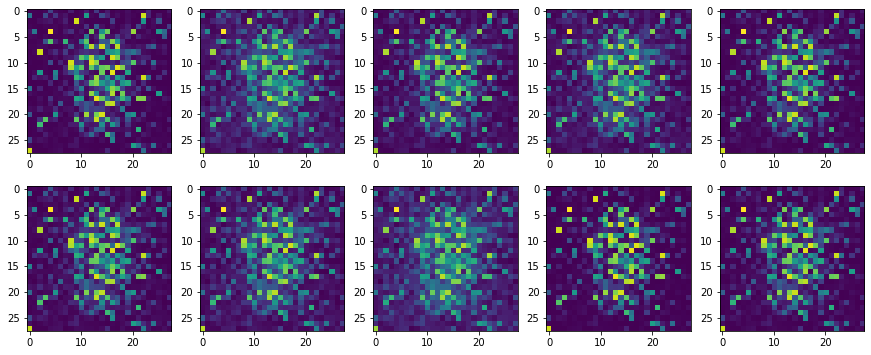

In [179]:
import numpy as np

noise = tf.random.normal([10, 100])

output = gan_generator(noise)
output = np.squeeze(output.numpy())

plt.figure(figsize=(15,6))
for i in range(1, 11):
    plt.subplot(2,5,i)
    plt.imshow(output[i-1])

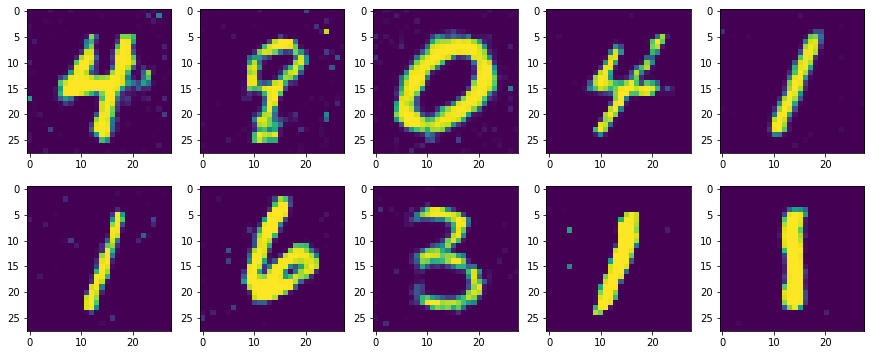

In [180]:
import os
weight_path = os.getenv('HOME')+'/aiffel/01_Exploration/E19/gan/GAN_500'

noise = tf.random.normal([10, 100]) 

gan_generator = GeneratorGAN()
gan_generator.load_weights(weight_path)

output = gan_generator(noise)
output = np.squeeze(output.numpy())

plt.figure(figsize=(15,6))
for i in range(1, 11):
    plt.subplot(2,5,i)
    plt.imshow(output[i-1])

## cGAN으로 MNIST 학습하기

In [181]:
cgan_generator = GeneratorCGAN()
cgan_discriminator = DiscriminatorCGAN()

@tf.function()
def cgan_step(real_images, labels):
    noise = tf.random.normal([real_images.shape[0], 100])
    
    with tf.GradientTape(persistent=True) as tape:
        fake_images = cgan_generator(noise, labels)
        
        real_out = cgan_discriminator(real_images, labels)
        fake_out = cgan_discriminator(fake_images, labels)
        
        gene_loss = generator_loss(fake_out)
        disc_loss = discriminator_loss(real_out, fake_out)
    
    gene_grad = tape.gradient(gene_loss, cgan_generator.trainable_variables)
    disc_grad = tape.gradient(disc_loss, cgan_discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_grad, cgan_generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_grad, cgan_discriminator.trainable_variables))
    return gene_loss, disc_loss


EPOCHS = 1
for epoch in range(1, EPOCHS+1):
    
    for i, (images, labels) in enumerate(cgan_datasets):
        gene_loss, disc_loss = cgan_step(images, labels)
    
        if (i+1) % 100 == 0:
            print(f"[{epoch}/{EPOCHS} EPOCHS, {i} ITER] G:{gene_loss}, D:{disc_loss}")

[1/1 EPOCHS, 99 ITER] G:5.722447395324707, D:0.00639666523784399
[1/1 EPOCHS, 199 ITER] G:5.23006534576416, D:0.00856637954711914
[1/1 EPOCHS, 299 ITER] G:2.948694944381714, D:0.16792333126068115
[1/1 EPOCHS, 399 ITER] G:4.031630516052246, D:0.133205845952034


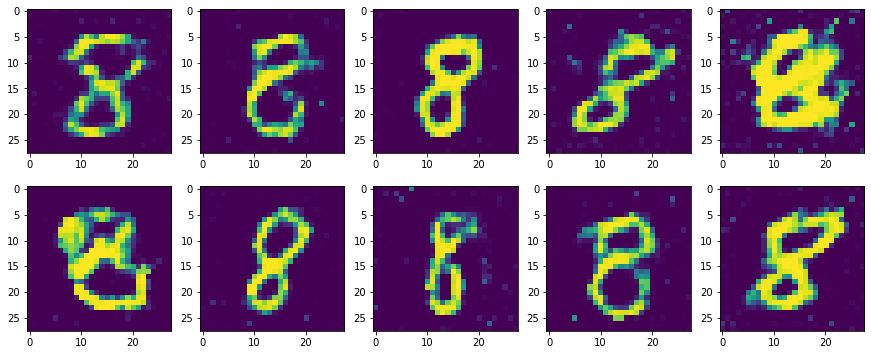

In [182]:
number = 8  # TODO : 생성할 숫자를 입력해 주세요!!

weight_path = os.getenv('HOME')+'/aiffel/01_Exploration/E19/cgan/CGAN_500'

noise = tf.random.normal([10, 100])

label = tf.one_hot(number, 10)
label = tf.expand_dims(label, axis=0)
label = tf.repeat(label, 10, axis=0)

generator = GeneratorCGAN()
generator.load_weights(weight_path)

output = generator(noise, label)
output = np.squeeze(output.numpy())

plt.figure(figsize=(15,6))
for i in range(1, 11):
    plt.subplot(2,5,i)
    plt.imshow(output[i-1])

# 데이터 준비하기
---

In [183]:
import os

data_path = os.getenv('HOME')+'/aiffel/01_Exploration/E19/data/pokemon_pix2pix_dataset/train/'
print("number of train examples :", len(os.listdir(data_path)))

number of train examples : 830


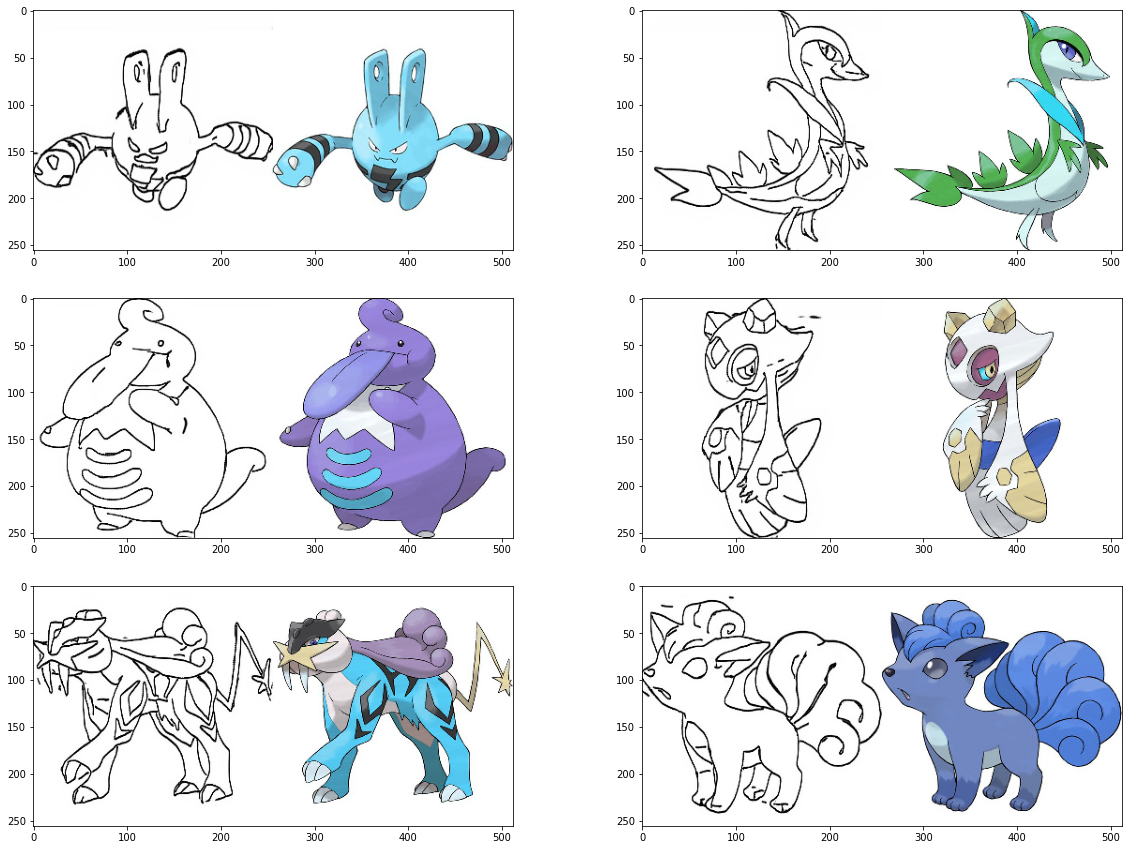

In [184]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = data_path + os.listdir(data_path)[np.random.randint(800)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

In [185]:
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


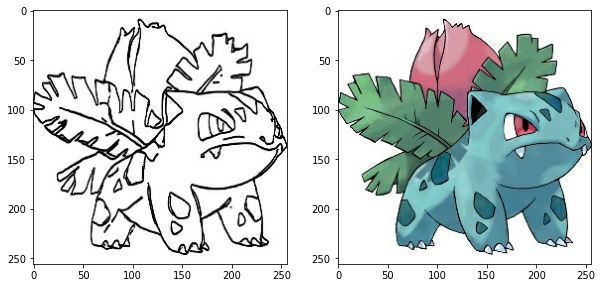

In [186]:
import tensorflow as tf

def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    sketch = img[:, :w, :] 
    sketch = tf.cast(sketch, tf.float32)
    colored = img[:, w:, :] 
    colored = tf.cast(colored, tf.float32)
    return normalize(sketch), normalize(colored)

f = data_path + os.listdir(data_path)[1]
sketch, colored = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(sketch))
plt.subplot(1,2,2); plt.imshow(denormalize(colored))

In [187]:
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(sketch, colored):
    stacked = tf.concat([sketch, colored], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]   

print("✅")

✅


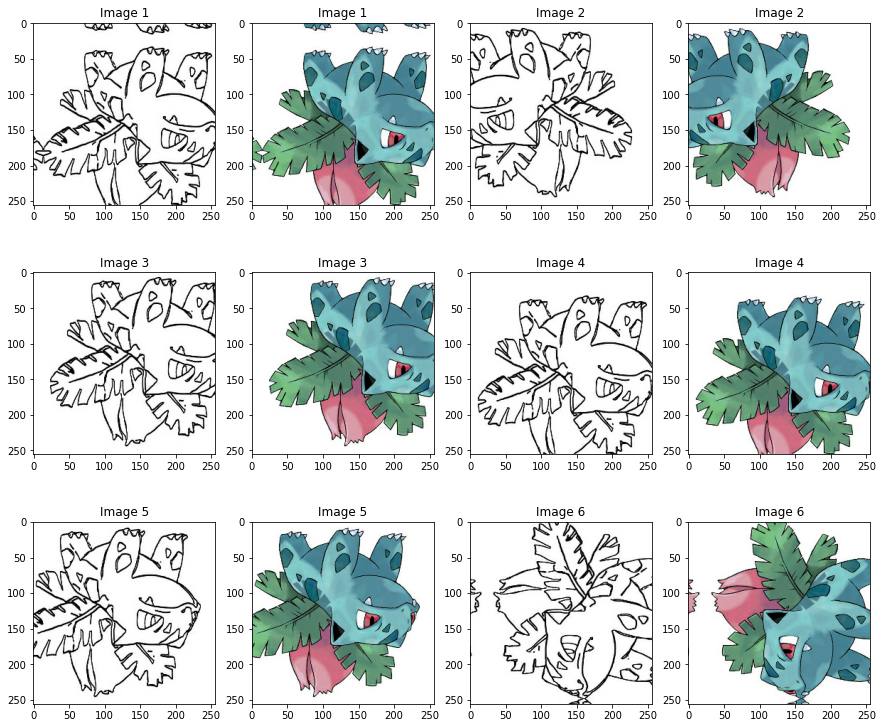

In [188]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_sketch, augmented_colored = apply_augmentation(sketch, colored)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_sketch)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")
    img_n += 1

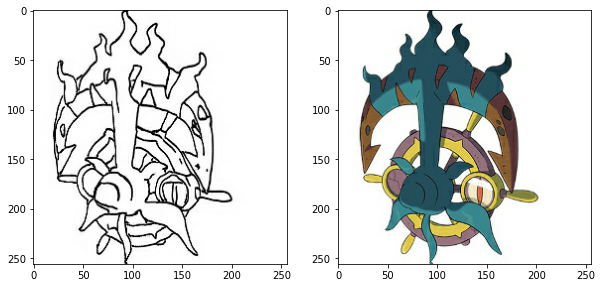

In [189]:
from tensorflow import data

def get_train(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return sketch, colored

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))

# Generator 구성하기
---

In [190]:
from tensorflow.keras import layers, Input, Model

class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu= layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

print("✅")

✅


In [191]:
class Encoder(layers.Layer):
    def __init__(self):
        super(Encoder, self).__init__()
        filters = [64,128,256,512,512,512,512,512]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i == 0:
                self.blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.blocks.append(EncodeBlock(f))
    
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
    
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

print("✅")

✅


In [192]:
Encoder().get_summary()

Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, 256, 256, 3)]     0         
_________________________________________________________________
encode_block_144 (EncodeBloc (None, 128, 128, 64)      3072      
_________________________________________________________________
encode_block_145 (EncodeBloc (None, 64, 64, 128)       131584    
_________________________________________________________________
encode_block_146 (EncodeBloc (None, 32, 32, 256)       525312    
_________________________________________________________________
encode_block_147 (EncodeBloc (None, 16, 16, 512)       2099200   
_________________________________________________________________
encode_block_148 (EncodeBloc (None, 8, 8, 512)         4196352   
_________________________________________________________________
encode_block_149 (EncodeBloc (None, 4, 4, 512)         419

In [193]:
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

    
class Decoder(layers.Layer):
    def __init__(self):
        super(Decoder, self).__init__()
        filters = [512,512,512,512,256,128,64]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i < 3:
                self.blocks.append(DecodeBlock(f))
            else:
                self.blocks.append(DecodeBlock(f, dropout=False))
                
        self.blocks.append(layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False))
        
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
            
    def get_summary(self, input_shape=(1,1,512)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()
        
print("✅")

✅


In [194]:
Decoder().get_summary()

Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        [(None, 1, 1, 512)]       0         
_________________________________________________________________
decode_block_126 (DecodeBloc (None, 2, 2, 512)         4196352   
_________________________________________________________________
decode_block_127 (DecodeBloc (None, 4, 4, 512)         4196352   
_________________________________________________________________
decode_block_128 (DecodeBloc (None, 8, 8, 512)         4196352   
_________________________________________________________________
decode_block_129 (DecodeBloc (None, 16, 16, 512)       4196352   
_________________________________________________________________
decode_block_130 (DecodeBloc (None, 32, 32, 256)       2098176   
_________________________________________________________________
decode_block_131 (DecodeBloc (None, 64, 64, 128)       524

In [195]:
class EncoderDecoderGenerator(Model):
    def __init__(self):
        super(EncoderDecoderGenerator, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def call(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
   
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()
        

EncoderDecoderGenerator().get_summary()

Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        [(None, 256, 256, 3)]     0         
_________________________________________________________________
encoder_5 (Encoder)          (None, 1, 1, 512)         19544576  
_________________________________________________________________
decoder_5 (Decoder)          (None, 256, 256, 3)       19542784  
Total params: 39,087,360
Trainable params: 39,076,480
Non-trainable params: 10,880
_________________________________________________________________


# GENERATOR 재구성하기
---

In [196]:
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

    
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)
    
print("✅")

✅


In [197]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

print("✅")

✅


In [198]:
UNetGenerator().get_summary()

Model: "model_18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_22 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block_160 (EncodeBlock)  (None, 128, 128, 64) 3072        input_22[0][0]                   
__________________________________________________________________________________________________
encode_block_161 (EncodeBlock)  (None, 64, 64, 128)  131584      encode_block_160[0][0]           
__________________________________________________________________________________________________
encode_block_162 (EncodeBlock)  (None, 32, 32, 256)  525312      encode_block_161[0][0]           
___________________________________________________________________________________________

# Discriminator 구성하기
---

In [199]:
 class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

print("✅")

✅


In [200]:
inputs = Input((128,128,32))
out = layers.ZeroPadding2D()(inputs)
out = layers.Conv2D(64, 4, 1, "valid", use_bias=False)(out)
out = layers.BatchNormalization()(out)
out = layers.LeakyReLU(0.2)(out)

Model(inputs, out).summary()

Model: "model_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        [(None, 128, 128, 32)]    0         
_________________________________________________________________
zero_padding2d_32 (ZeroPaddi (None, 130, 130, 32)      0         
_________________________________________________________________
conv2d_245 (Conv2D)          (None, 127, 127, 64)      32768     
_________________________________________________________________
batch_normalization_362 (Bat (None, 127, 127, 64)      256       
_________________________________________________________________
leaky_re_lu_230 (LeakyReLU)  (None, 127, 127, 64)      0         
Total params: 33,024
Trainable params: 32,896
Non-trainable params: 128
_________________________________________________________________


In [201]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()
    
print("✅")

✅


In [202]:
Discriminator().get_summary()

Model: "model_20"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_24 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_25 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_57 (Concatenate)    (None, 256, 256, 6)  0           input_24[0][0]                   
                                                                 input_25[0][0]                   
__________________________________________________________________________________________________
disc_block_75 (DiscBlock)       (None, 128, 128, 64) 6144        concatenate_57[0][0]      

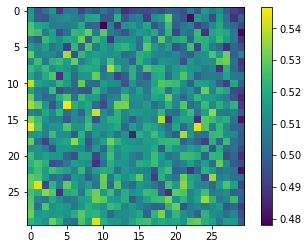

In [203]:
x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()

# 학습 및 테스트 하기
---

In [204]:
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

print("✅")

✅


In [205]:
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

print("✅")

✅


In [206]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

print("✅")

✅


In [207]:
EPOCHS = 10 #약 30분 정도 소요 됩니다.

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
                
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[10]                     
Generator_loss:0.9688                     
L1_loss:0.4794                     
Discriminator_loss:1.1493

EPOCH[1] - STEP[20]                     
Generator_loss:0.8155                     
L1_loss:0.2943                     
Discriminator_loss:1.3131

EPOCH[1] - STEP[30]                     
Generator_loss:0.7774                     
L1_loss:0.3311                     
Discriminator_loss:1.2512

EPOCH[1] - STEP[40]                     
Generator_loss:1.0649                     
L1_loss:0.2886                     
Discriminator_loss:1.2014

EPOCH[1] - STEP[50]                     
Generator_loss:1.3719                     
L1_loss:0.2594                     
Discriminator_loss:0.9974

EPOCH[1] - STEP[60]                     
Generator_loss:1.1824                     
L1_loss:0.2793                     
Discriminator_loss:0.6344

EPOCH[1] - STEP[70]                     
Generator_loss:1.8816                     
L1_loss:0.2569                    

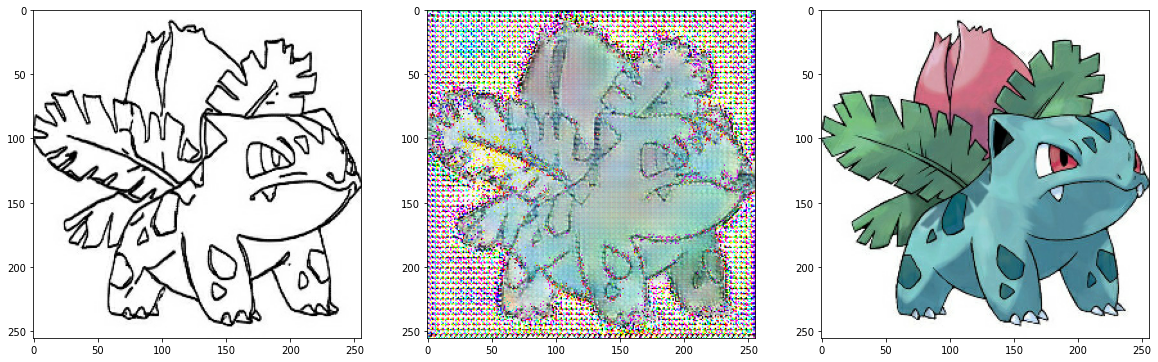

In [208]:
test_ind = 1

f = data_path + os.listdir(data_path)[test_ind]
sketch, colored = load_img(f)

pred = generator(tf.expand_dims(sketch, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(sketch))
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.imshow(denormalize(colored))

# 프로젝트 수행
---

## STEP0. 데이터 준비하기

In [268]:
data_path = os.getenv('HOME')+'/aiffel/01_Exploration/E19/pjt/cityscapes/train/'

print("number of train examples :", len(os.listdir(data_path)))

number of train examples : 1000


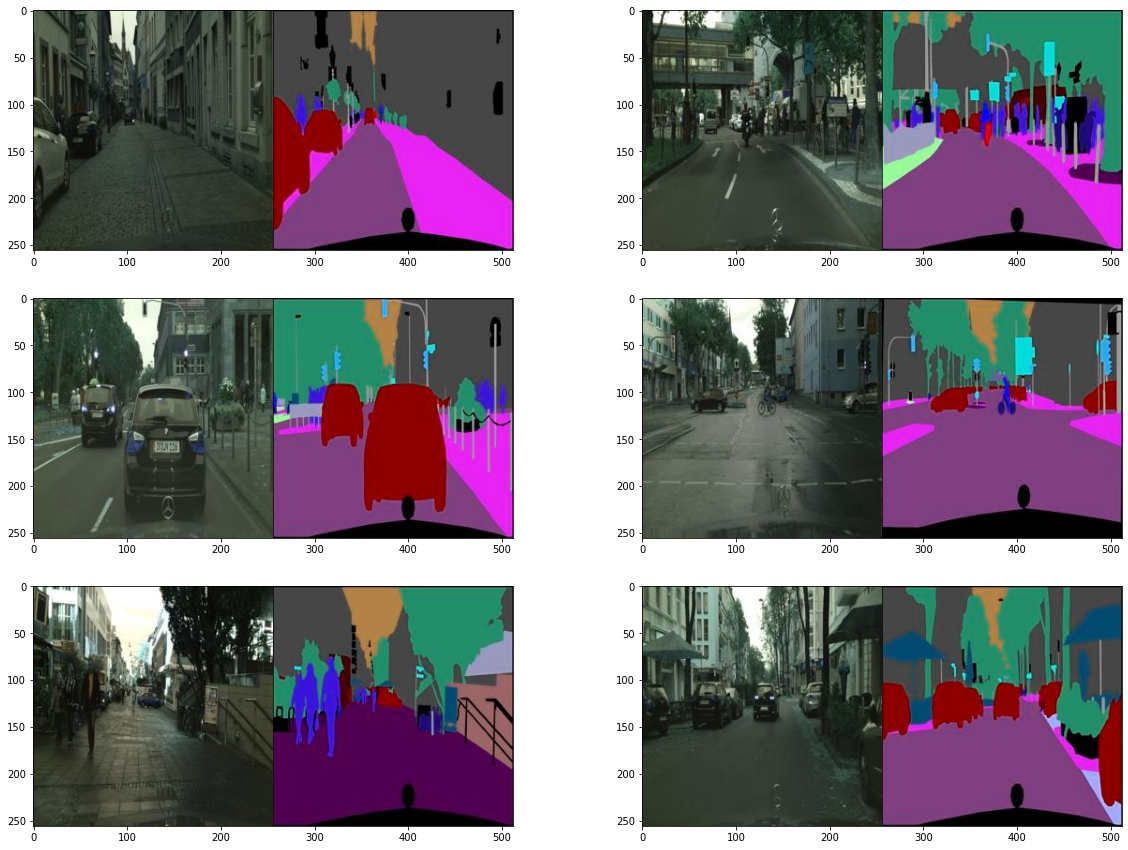

In [269]:
plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = data_path + os.listdir(data_path)[np.random.randint(1000)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

In [270]:
# Image Size Check
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


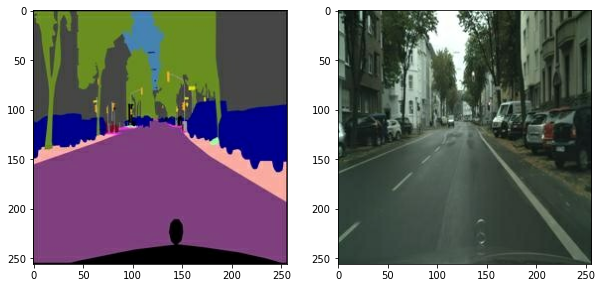

In [271]:
f = data_path + os.listdir(data_path)[1]
colored, sketch =  load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(sketch))
plt.subplot(1,2,2); plt.imshow(denormalize(colored))

## STEP1. 데이터에 한 가지 이상의 augmentation 방법을 적용하여 학습해주세요.
(좌우반전, 상하반전, 90도 Rotate, 일정영역 crop 후 해당 부위 padding 처리 적용 - 노드 동일)

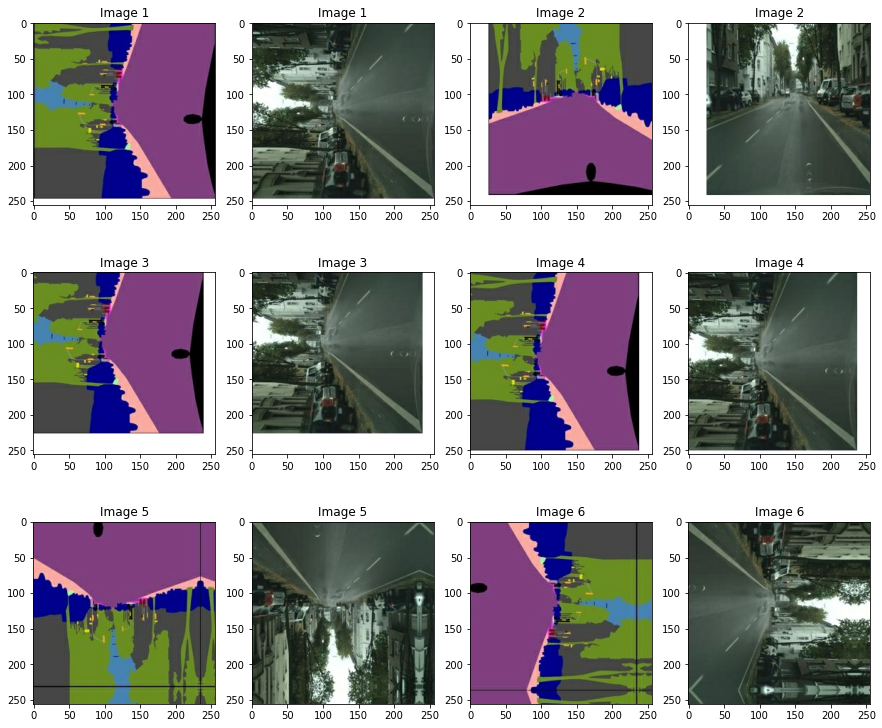

In [272]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_sketch, augmented_colored = apply_augmentation(sketch, colored)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_sketch)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")
    img_n += 1

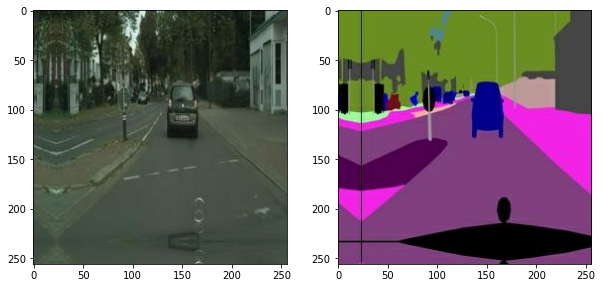

In [273]:
train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))

## STEP2. 이전에 구현했던 두 개의 Generator 중 Encoder와 Decoder간에 skip connection이 있는 U-Net Generator를 사용해주세요.

In [274]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()
    
UNetGenerator().get_summary()

Model: "model_29"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_38 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block_240 (EncodeBlock)  (None, 128, 128, 64) 3072        input_38[0][0]                   
__________________________________________________________________________________________________
encode_block_241 (EncodeBlock)  (None, 64, 64, 128)  131584      encode_block_240[0][0]           
__________________________________________________________________________________________________
encode_block_242 (EncodeBlock)  (None, 32, 32, 256)  525312      encode_block_241[0][0]           
___________________________________________________________________________________________

In [275]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()
    
Discriminator().get_summary()

Model: "model_30"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_39 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_40 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_509 (Concatenate)   (None, 256, 256, 6)  0           input_39[0][0]                   
                                                                 input_40[0][0]                   
__________________________________________________________________________________________________
disc_block_130 (DiscBlock)      (None, 128, 128, 64) 6144        concatenate_509[0][0]     

## STEP3. 모델 학습 후, 학습된 Generator를 이용해 테스트합니다. 테스트 데이터는 다운받았던 "val" 폴더 내 이미지를 사용해주세요.

In [276]:
# 손실 함수
bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

print("✅")

✅


In [277]:
# optimikzer
gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

print("✅")

✅


In [278]:
# L1 loss를 포함한 업데이트 과정

generator = UNetGenerator()
discriminator = Discriminator()

@tf.function
def train_step(seg, real_img):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_img = generator(seg, training=True)
        # Discriminator 예측
        fake_disc = discriminator(seg, fake_img, training=True)
        real_disc = discriminator(seg, real_img, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_img, real_img, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

In [ ]:
EPOCHS = 20 #약 30분 정도 소요 됩니다.

history = {'epoch(step)' : [], 'gene_loss':[], 'L1_loss':[], 'disc_loss': []}

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
                
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 10 == 0:
            # result save
            history['epoch(step)'].append(f'{epoch}({i+1:3d})')
            history['gene_loss'].append(f'{g_loss:.4f}')
            history['L1_loss'].append(f'{l1_loss:.4f}')
            history['disc_loss'].append(f'{d_loss: .4f}')
            
            # result display
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[10]                     
Generator_loss:2.6119                     
L1_loss:0.1320                     
Discriminator_loss:0.1587

EPOCH[1] - STEP[20]                     
Generator_loss:5.8333                     
L1_loss:0.1303                     
Discriminator_loss:1.3471

EPOCH[1] - STEP[30]                     
Generator_loss:3.1619                     
L1_loss:0.0879                     
Discriminator_loss:0.5684

EPOCH[1] - STEP[40]                     
Generator_loss:3.5685                     
L1_loss:0.1412                     
Discriminator_loss:0.1284

EPOCH[1] - STEP[50]                     
Generator_loss:1.9439                     
L1_loss:0.1466                     
Discriminator_loss:0.2412

EPOCH[1] - STEP[60]                     
Generator_loss:2.8976                     
L1_loss:0.1363                     
Discriminator_loss:0.1568

EPOCH[1] - STEP[70]                     
Generator_loss:0.4070                     
L1_loss:0.1485                    

## STEP4. 1개 이상의 이미지에 대해 테스트 과정을 거친 후 그 결과를 스케치, 생성된 사진, 실제 사진 순서로 나란히 시각화해 주세요.

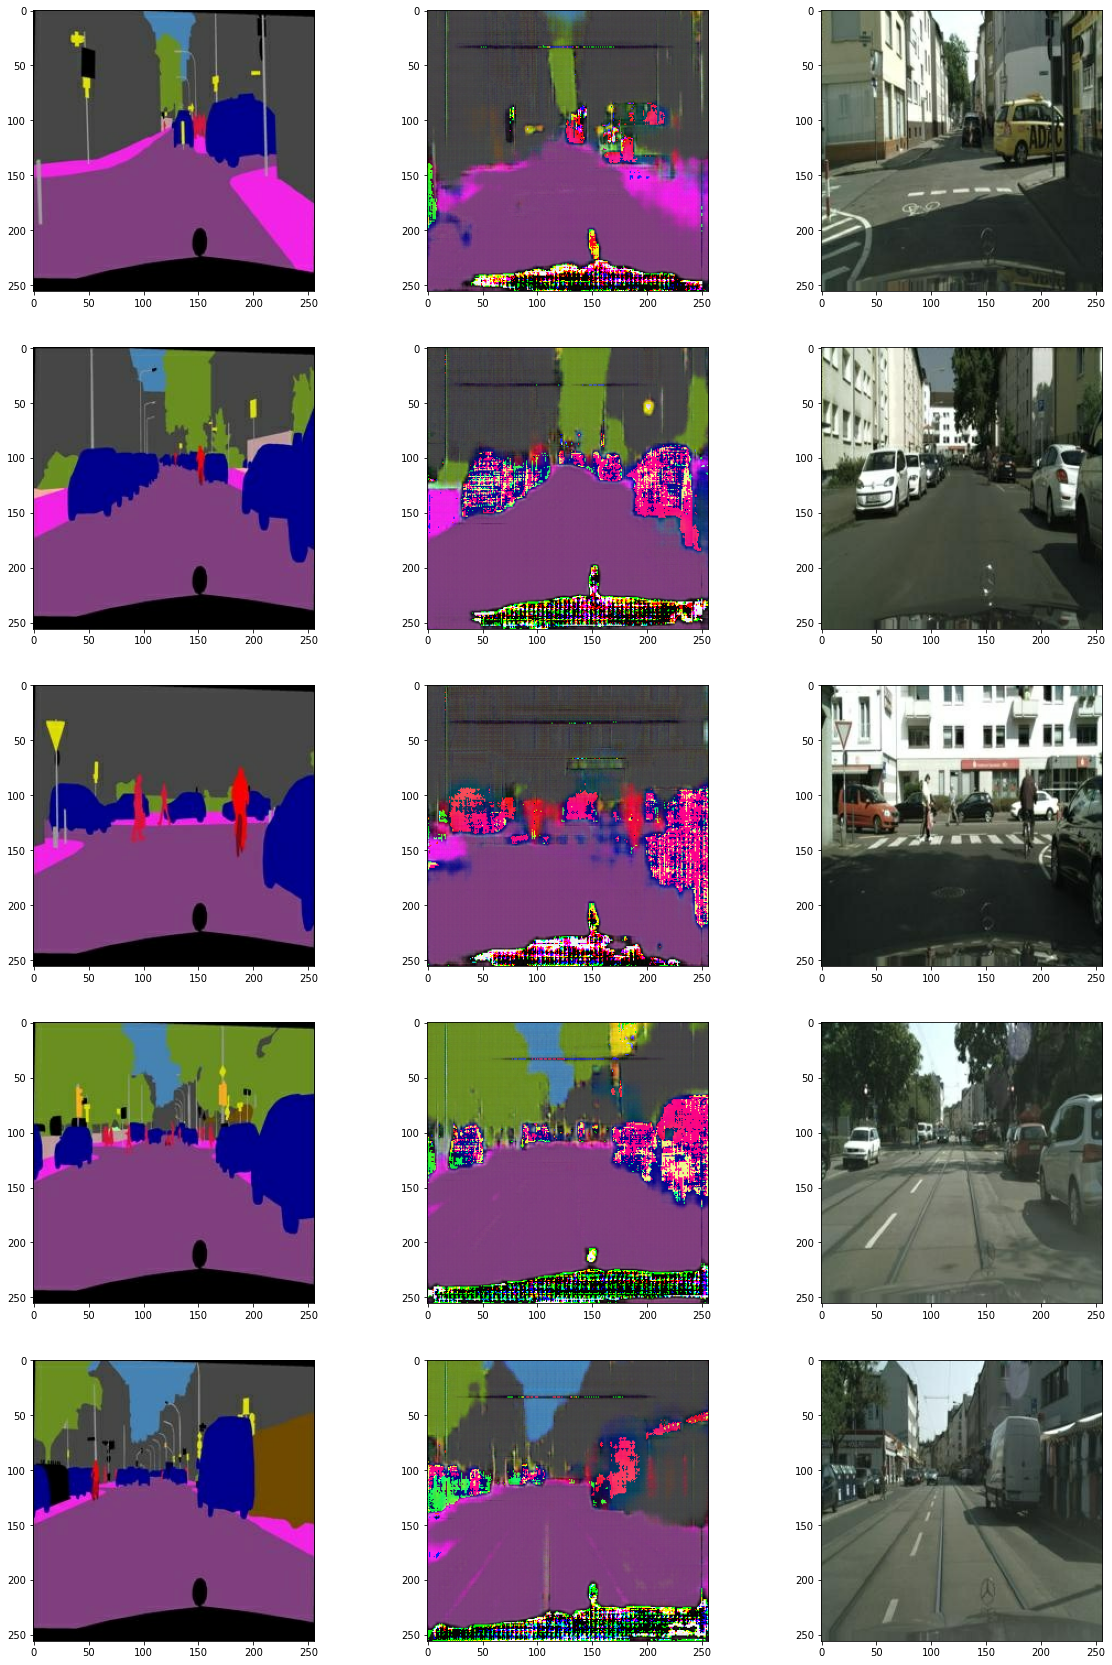

In [290]:
test_cnt = 5
tmp = 0
val_path = os.getenv('HOME')+'/aiffel/01_Exploration/E19/pjt/cityscapes/val/'

plt.figure(figsize=(20,30))
for i in range(test_cnt):
    f = val_path + f'{i+1}.jpg'
    sketch, colored = load_img(f)

    pred = generator(tf.expand_dims(sketch, 0))
    pred = denormalize(pred)    
    
    plt.subplot(5,3,i*3+1); plt.imshow(denormalize(colored))
    plt.subplot(5,3,i*3+2); plt.imshow(pred[0])
    plt.subplot(5,3,i*3+3); plt.imshow(denormalize(sketch))

## STEP5. 모델을 충분히 학습하기에 시간이 부족할 수 있습니다. 적어도 10 epoch 이상 학습하며 중간 손실 값에 대한 로그를 남겨주세요. 좋은 결과를 얻기 위해선 긴 학습 시간이 필요하므로 테스트 결과는 만족스럽지 않아도 괜찮습니다.

In [281]:
import pandas as pd

# 모든 행을 출력하기 위함
pd.set_option('display.max_row', None) 
df = pd.DataFrame(history)
df

epoch(step) gene_loss L1_loss disc_loss
0         1( 10)    0.9398  0.3354    1.1789
1         1( 20)    1.0448  0.3371    0.9571
2         1( 30)    1.3200  0.3020    0.9666
3         1( 40)    1.6985  0.2568    0.5246
4         1( 50)    1.2036  0.2887    0.7811
5         1( 60)    1.3831  0.2314    0.9527
6         1( 70)    1.6210  0.2537    0.5261
7         1( 80)    1.7954  0.2063    0.5544
8         1( 90)    1.9911  0.2875    0.7560
9         1(100)    1.9808  0.2550    1.1140
10        1(110)    2.0860  0.2265    0.6081
11        1(120)    1.8786  0.2085    0.4426
12        1(130)    2.6352  0.2640    0.3796
13        1(140)    1.5331  0.2593    0.5923
14        1(150)    1.9282  0.2356    1.0451
15        1(160)    2.5047  0.2697    0.9305
16        1(170)    1.7953  0.2543    0.8264
17        1(180)    1.6220  0.2547    0.6038
18        1(190)    1.5005  0.2461    0.6470
19        1(200)    2.6487  0.2516    0.5392
20        1(210)    1.2910  0.2752    0.7312
21        1(220)    1.6759  0.2089    0.9535
22        1(230)    0.9985  0.2232    1.4209
23        1(240)    1.4873  0.2454    0.8962
24        1(250)    2.0674  0.2563    0.7539
25        2( 10)    1.4359  0.2559    0.7423
26        2( 20)    1.4853  0.2460    0.4968
27        2( 30)    1.2398  0.2045    1.3698
28        2( 40)    1.7770  0.2300    0.4128
29        2( 50)    0.8124  0.2537    1.0278
30        2( 60)    2.9986  0.2566    0.2338
31        2( 70)    2.1513  0.2242    0.3458
32        2( 80)    1.1801  0.2186    0.6787
33        2( 90)    1.5620  0.2086    0.9341
34        2(100)    2.1916  0.1690    1.3530
35        2(110)    1.6327  0.2564    0.3492
36        2(120)    2.1561  0.2222    0.8055
37        2(130)    1.7605  0.2141    0.8031
38        2(140)    1.2401  0.1824    0.5929
39        2(150)    1.8247  0.1906    1.1563
40        2(160)    2.0220  0.1888    1.0388
41        2(170)    0.4032  0.1884    1.5077
42        2(180)    2.0422  0.2124    0.7885
43        2(190)    1.4786  0.1758    0.7204
44        2(200)    1.9138  0.2231    0.9496
45        2(210)    1.7013  0.2192    0.4420
46        2(220)    2.5451  0.1905    0.4266
47        2(230)    2.5007  0.1811    0.9910
48        2(240)    0.7317  0.1807    1.1308
49        2(250)    2.5799  0.1756    0.8358
50        3( 10)    1.4111  0.2449    0.5175
51        3( 20)    2.3263  0.1863    1.0353
52        3( 30)    2.0609  0.2019    1.0984
53        3( 40)    1.1460  0.2282    1.0710
54        3( 50)    3.0883  0.2529    0.2513
55        3( 60)    0.8779  0.2512    0.7676
56        3( 70)    0.9934  0.1961    1.1510
57        3( 80)    1.4945  0.1966    1.0701
58        3( 90)    0.5735  0.2442    1.1900
59        3(100)    1.8803  0.1920    0.7665
60        3(110)    1.8124  0.2107    0.4854
61        3(120)    0.7056  0.2165    1.0855
62        3(130)    1.6338  0.1827    0.4778
63        3(140)    1.8093  0.1800    0.4381
64        3(150)    1.6498  0.2227    0.5223
65        3(160)    2.2791  0.1774    1.1851
66        3(170)    2.1536  0.1809    0.5386
67        3(180)    1.4041  0.1935    0.4924
68        3(190)    2.7275  0.1888    0.9264
69        3(200)    2.8228  0.1860    0.6398
70        3(210)    1.4249  0.1632    0.7659
71        3(220)    0.6808  0.2036    1.0279
72        3(230)    1.1433  0.1943    0.6441
73        3(240)    3.1636  0.1740    0.6060
74        3(250)    1.1334  0.2172    0.5730
75        4( 10)    2.4696  0.1536    1.2378
76        4( 20)    2.4419  0.2025    0.7292
77        4( 30)    1.7535  0.1947    1.0892
78        4( 40)    1.9748  0.2377    0.3359
79        4( 50)    1.7250  0.1958    0.8788
80        4( 60)    1.5590  0.1893    0.8282
81        4( 70)    0.6417  0.1824    1.0208
82        4( 80)    1.6913  0.1518    0.8950
83        4( 90)    2.1259  0.1814    0.6183
84        4(100)    0.8375  0.1576    1.7850
85        4(110)    2.2253  0.1633    1.3535
86        4(120)    1.0782  0.1756    0.6381
87        4(130)    1.8677  0.2252    0.5312


# 루브릭
---

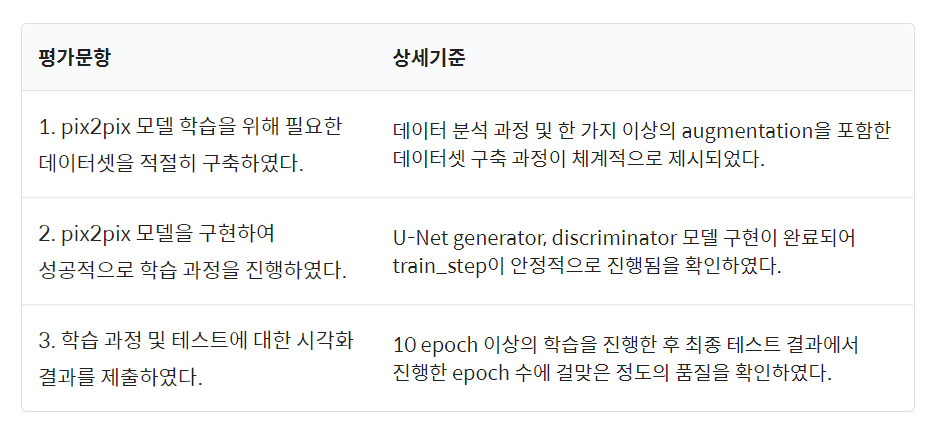

# 회고
---

- 이번 프로젝트에서 **어려웠던 점,**
- 프로젝트를 진행하면서 **알아낸 점** 혹은 **아직 모호한 점**.
- 루브릭 평가 지표를 맞추기 위해 **시도한 것들**.
- 만약에 루브릭 평가 관련 지표를 **달성 하지 못했을 때, 이유에 관한 추정**.
- **자기 다짐**

In [ ]:
이번 프로젝트에서 어려웠던점은 시간과의 싸움이였다... 기존 루브릭에 10회 이상만 학습을 해보라고 했는디 욕심이 나서 100epoch로 학습을 해봤지만 더 많은 epoch로 학습을 진행하고 싶었지만(1000회 정도...?) 
시간이 부족하여 결과물이 만족스럽지 않아서 아쉬웠다.     

그래도 cGan, UNET, pix2pix 모델등에 대한 세부적힌 로직을 확인할 수 있는 노드여서 좋았다. 좀 더 다른 블로그들로 부족한 지식을 채워야겠다.